In [1]:
import pandas as pd

In [2]:
crime = pd.read_csv("crime_preprocessed_rf")

In [4]:
violent_crime_list = [3, 10, 27, 21, 17, 20, 22, 15]
violent_crime = crime[crime['UCRdesc_numeric'].isin(violent_crime_list)]
crime = violent_crime

In [6]:
crime['OffenseDate'] = pd.to_datetime(crime['OffenseDate'], errors='coerce')
# Step 2: Set 'OffenseDate' as the index
crime.set_index('OffenseDate', inplace=True)

C:\Users\singh\AppData\Local\Temp\ipykernel_1352\2798066495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime['OffenseDate'] = pd.to_datetime(crime['OffenseDate'], errors='coerce')


In [7]:
# Step 3: Now group by 'CENSUS_BLOCK' and resample using the 'OffenseDate' index
crime_time_series = crime.groupby(['CENSUS_BLOCK', pd.Grouper(freq='W')]).agg({
    'DOW': 'mean',  
    'HourofDay': 'mean',
    'ExtractedMonth': 'mean',
    'ExtractedDay': 'mean',
}).reset_index()

# Step 4: Create the 'Crime_Count' feature based on size (count of crimes)
crime_time_series['Crime_Count_W'] = crime.groupby(['CENSUS_BLOCK', pd.Grouper(freq='W')]).size().values

# Now the 'violent_crime_time_series' contains the aggregated features and 'Crime_Count'
crime_time_series

,CENSUS_BLOCK,OffenseDate,DOW,HourofDay,ExtractedMonth,ExtractedDay,Crime_Count_W
0,Block 1000,2018-01-07,3.520000,9.920000,1.000000,4.080000,25
1,Block 1000,2018-01-14,4.062500,15.062500,1.000000,10.500000,16
2,Block 1000,2018-01-21,3.250000,15.666667,1.000000,18.500000,12
3,Block 1000,2018-01-28,4.208333,13.833333,1.000000,24.791667,24
4,Block 1000,2018-02-04,4.500000,11.642857,1.571429,14.571429,14
...,...,...,...,...,...,...,...
23962,Block 6006,2022-04-17,6.000000,14.000000,4.000000,15.000000,1
23963,Block 6006,2022-05-22,1.000000,11.000000,5.000000,22.000000,1
23964,Block 6006,2022-06-05,4.000000,8.000000,6.000000,1.000000,1
23965,Block 6006,2022-06-12,2.500000,8.000000,6.000000,10.000000,2


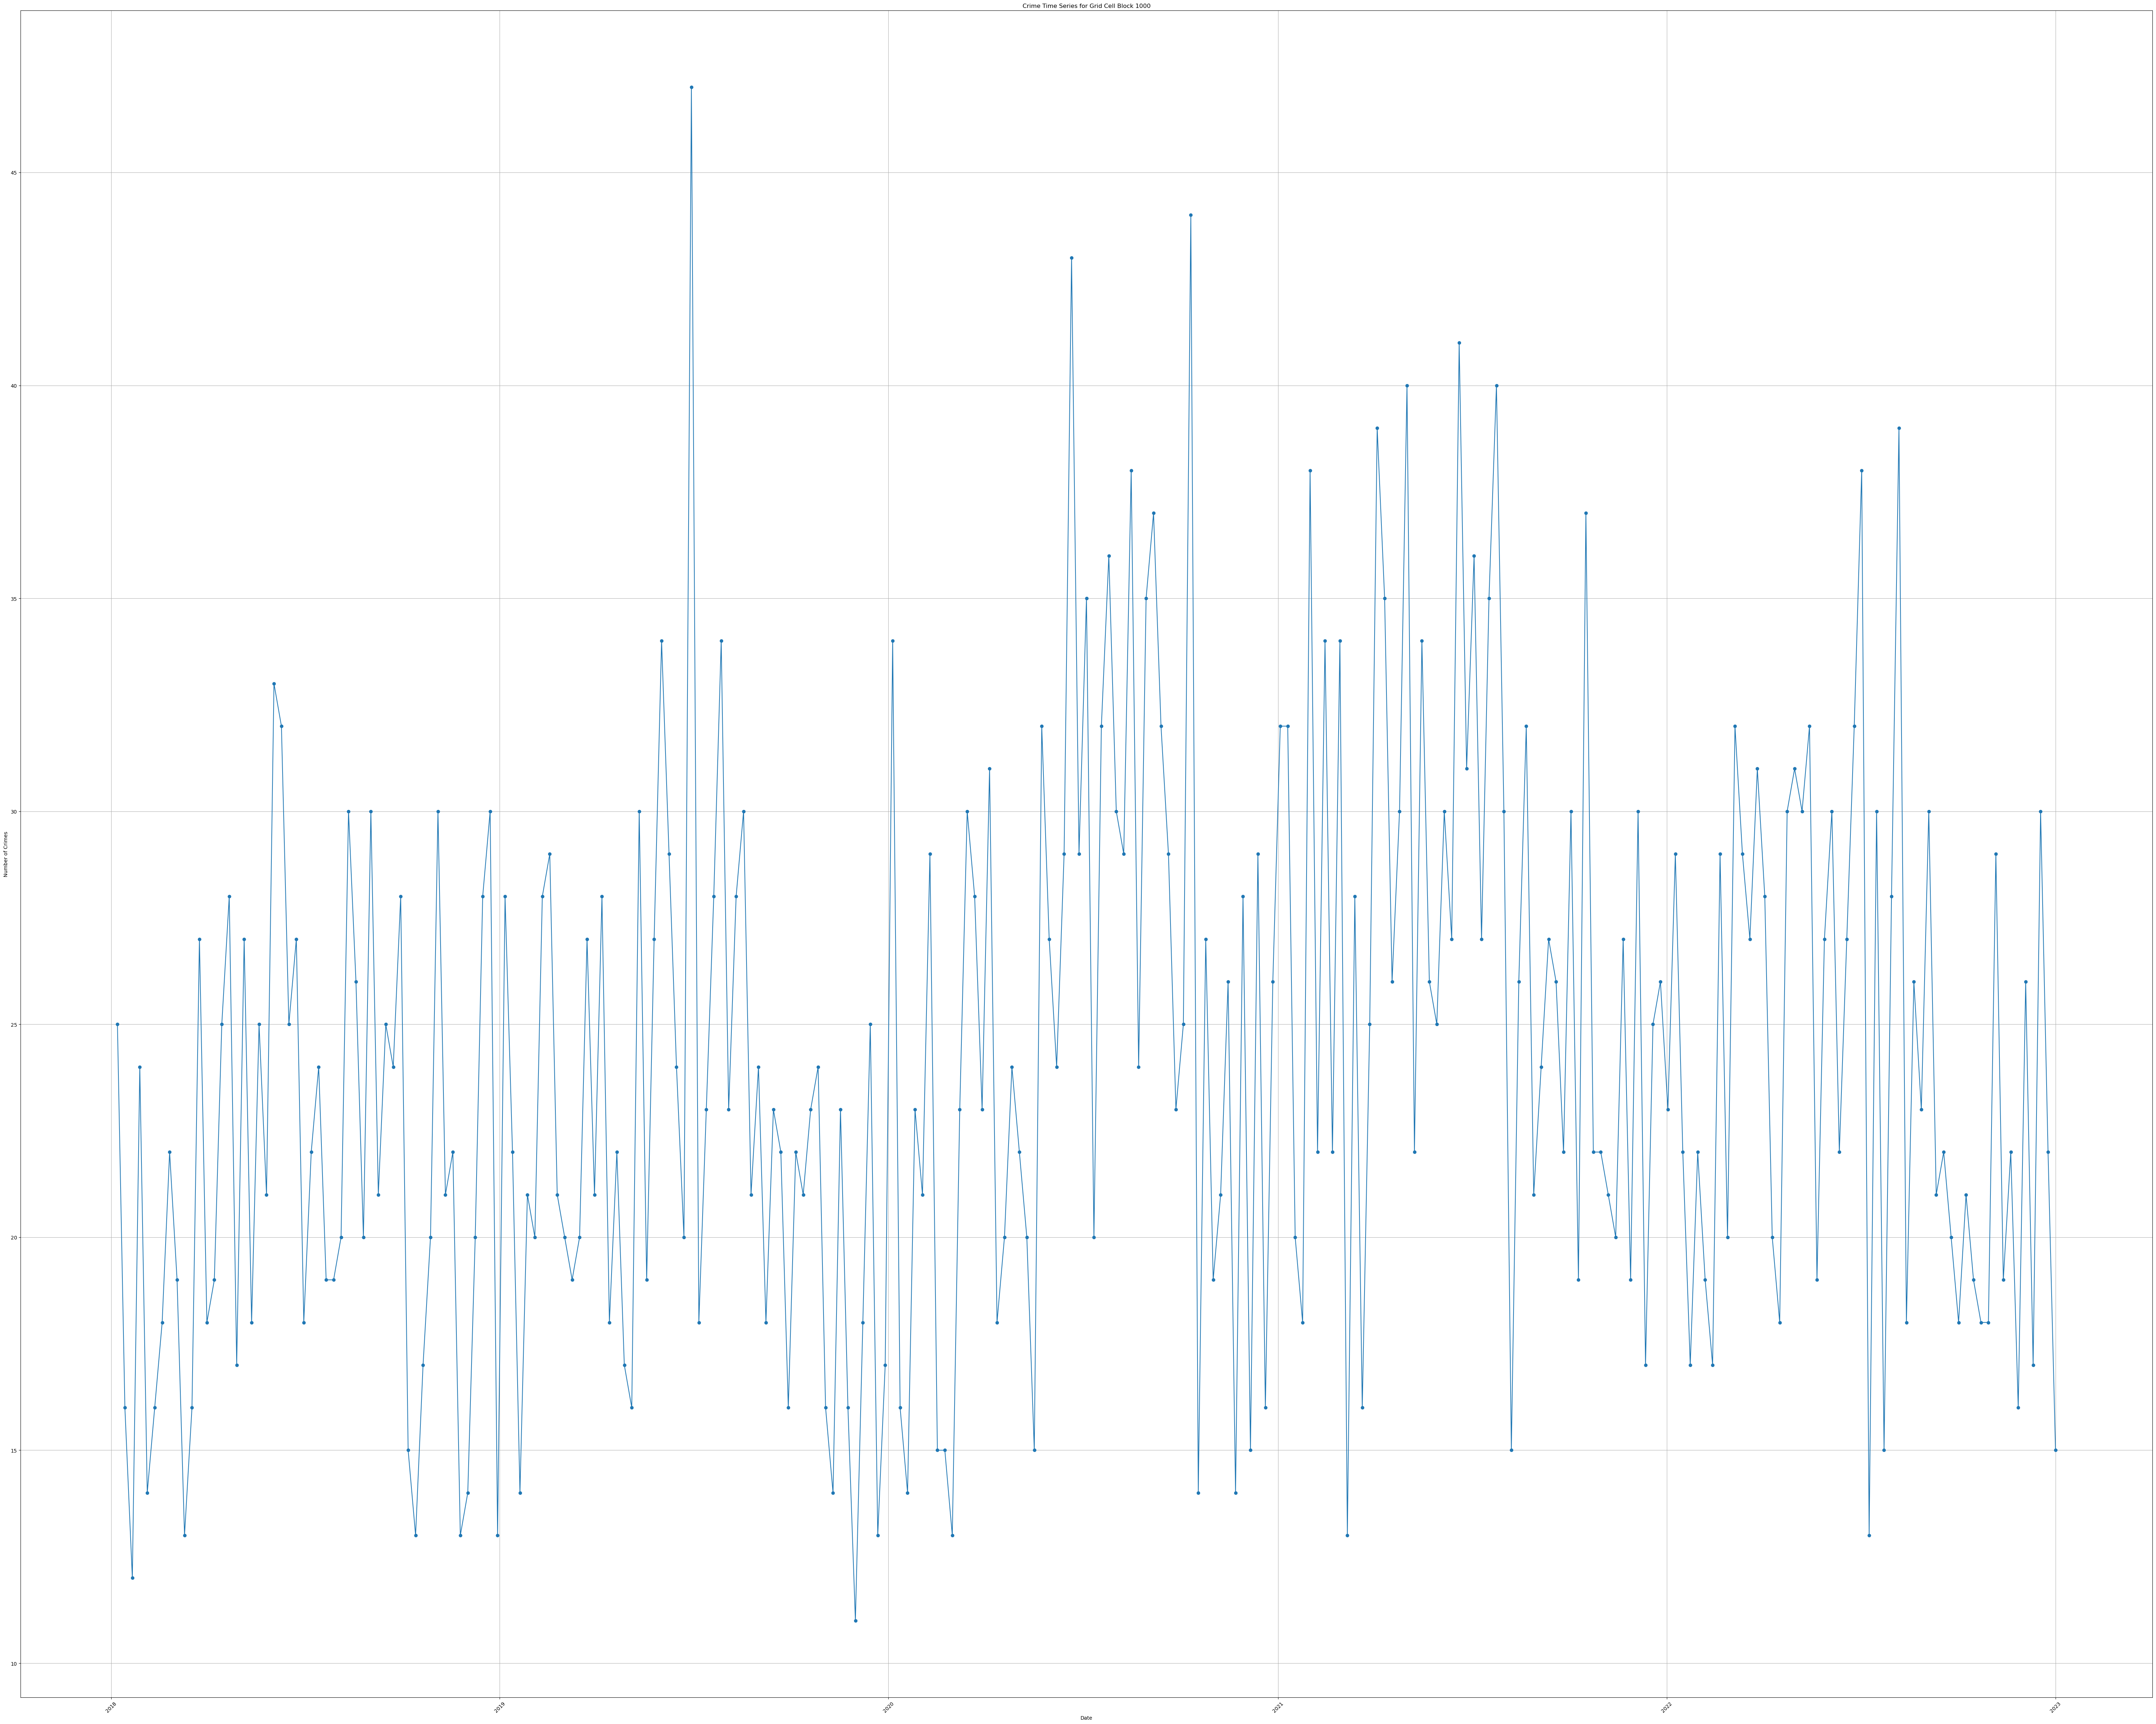

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for a specific CENSUS_BLOCK, e.g., (x, y)
block = 'Block 1000'
time_series_data = crime_time_series[crime_time_series['CENSUS_BLOCK'] == block]

# Plot the time series for that CENSUS_TRACT
plt.figure(figsize=(60, 48))
plt.plot(time_series_data['OffenseDate'], time_series_data['Crime_Count_W'], marker='o')
plt.title(f'Crime Time Series for Grid Cell {block}')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()

plt.show()

In [9]:
!pip install xgboost

In [10]:
# feature encode CENSUS_BLOCK
from sklearn.preprocessing import LabelEncoder

crime_time_series['CENSUS_BLOCK'] = crime_time_series['CENSUS_BLOCK'].apply(lambda x: str(x))

le = LabelEncoder()
crime_time_series['CENSUS_BLOCK'] = le.fit_transform(crime_time_series['CENSUS_BLOCK'])

In [11]:
census_tract_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the mappings
print("CENSUS_BLOCK to Encoded Label Mappings:")
for original, encoded in census_tract_mapping.items():
    print(f"{original} -> {encoded}")

CENSUS_BLOCK to Encoded Label Mappings:
Block 1000 -> 0
Block 1001 -> 1
Block 1002 -> 2
Block 1003 -> 3
Block 1004 -> 4
Block 1005 -> 5
Block 1006 -> 6
Block 1007 -> 7
Block 1008 -> 8
Block 1009 -> 9
Block 1010 -> 10
Block 1011 -> 11
Block 1012 -> 12
Block 1013 -> 13
Block 1014 -> 14
Block 1015 -> 15
Block 1016 -> 16
Block 1017 -> 17
Block 1018 -> 18
Block 1019 -> 19
Block 1020 -> 20
Block 1021 -> 21
Block 1022 -> 22
Block 1023 -> 23
Block 1024 -> 24
Block 1025 -> 25
Block 1026 -> 26
Block 1027 -> 27
Block 1028 -> 28
Block 1029 -> 29
Block 1030 -> 30
Block 1031 -> 31
Block 1032 -> 32
Block 1033 -> 33
Block 1034 -> 34
Block 1035 -> 35
Block 1036 -> 36
Block 1037 -> 37
Block 1038 -> 38
Block 1039 -> 39
Block 1040 -> 40
Block 1041 -> 41
Block 1042 -> 42
Block 1043 -> 43
Block 1044 -> 44
Block 1045 -> 45
Block 1046 -> 46
Block 1047 -> 47
Block 1048 -> 48
Block 1049 -> 49
Block 1050 -> 50
Block 1051 -> 51
Block 1052 -> 52
Block 1053 -> 53
Block 1059 -> 54
Block 1062 -> 55
Block 1066 -> 56
B

In [12]:
crime_time_series.columns

Index(['CENSUS_BLOCK', 'OffenseDate', 'DOW', 'HourofDay', 'ExtractedMonth',
       'ExtractedDay', 'Crime_Count_W'],
      dtype='object')

In [13]:
from sklearn.model_selection import train_test_split

features = ['DOW', 'HourofDay', 'ExtractedMonth', 'ExtractedDay', 'CENSUS_BLOCK']

X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

          Feature  Importance
4    CENSUS_BLOCK    0.767318
0             DOW    0.070317
1       HourofDay    0.062182
3    ExtractedDay    0.052997
2  ExtractedMonth    0.047186
Mean Absolute Error: 1.6686232790988738
Root Mean Squared Error: 2.678928616349772
R² Score: 0.780519201266645


C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


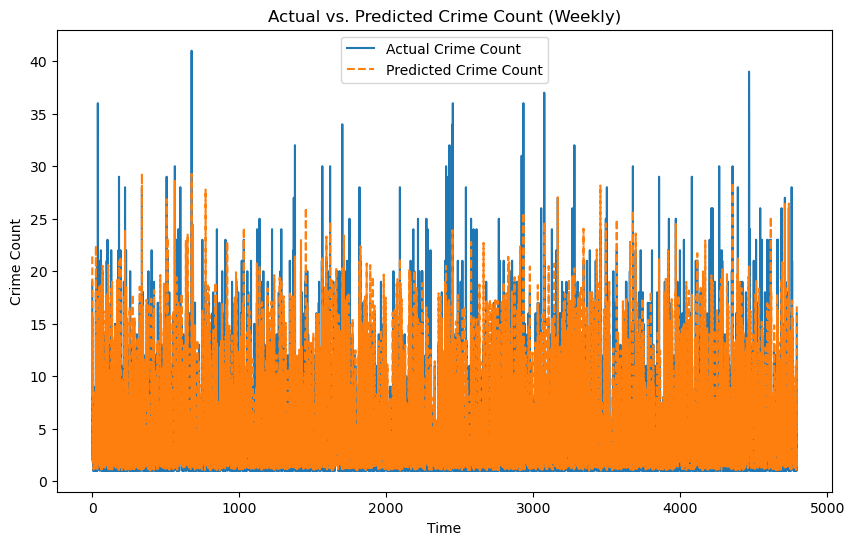

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

Mean Absolute Error: 1.5602815793415328
Root Mean Squared Error: 2.5757749222232302
R² Score: 0.7970962524414062


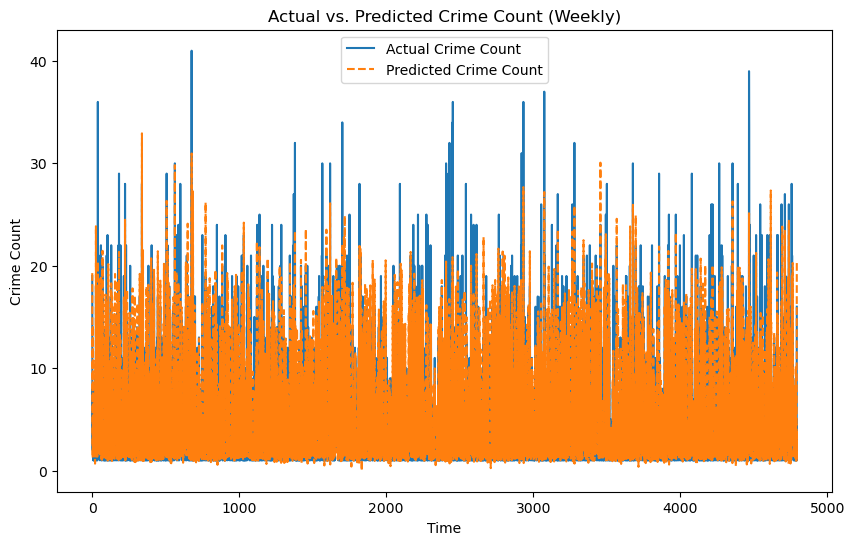

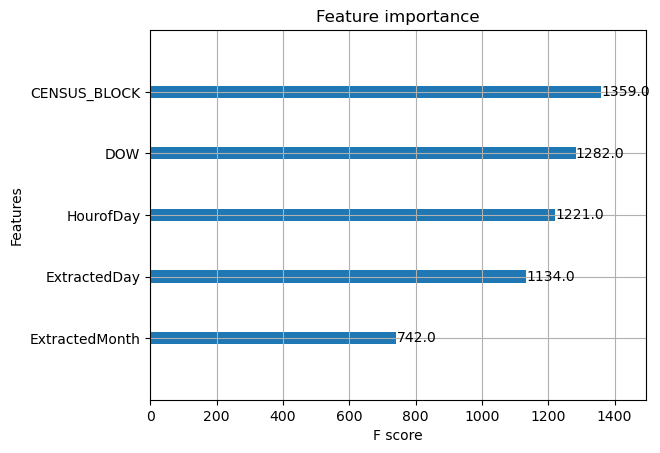

In [15]:
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Weekly)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

xgb.plot_importance(xgb_model)
plt.show()

In [16]:
# Step 3: Now group by 'CENSUS_TRACT' and resample using the 'OffenseDate' index
crime_time_series = crime.groupby(['CENSUS_BLOCK', pd.Grouper(freq='D')]).agg({
    'DOW': 'first',  
    'HourofDay': 'first',
    'ExtractedMonth': 'first',
    'ExtractedDay': 'first',
}).reset_index()

# Step 4: Create the 'Crime_Count' feature based on size (count of crimes)
crime_time_series['Crime_Count_D'] = crime.groupby(['CENSUS_BLOCK', pd.Grouper(freq='D')]).size().values

# Now the 'crime_time_series' contains the aggregated features and 'Crime_Count'
crime_time_series

,CENSUS_BLOCK,OffenseDate,DOW,HourofDay,ExtractedMonth,ExtractedDay,Crime_Count_D
0,Block 1000,2018-01-01,2,14,1,1,6
1,Block 1000,2018-01-02,2,23,1,2,4
2,Block 1000,2018-01-04,4,21,1,4,2
3,Block 1000,2018-01-05,6,4,1,5,4
4,Block 1000,2018-01-06,7,13,1,6,3
...,...,...,...,...,...,...,...
66965,Block 6006,2022-05-22,1,11,5,22,1
66966,Block 6006,2022-06-01,4,8,6,1,1
66967,Block 6006,2022-06-08,4,15,6,8,1
66968,Block 6006,2022-06-12,1,1,6,12,1


In [17]:
# feature encode CENSUS_TRACT
from sklearn.preprocessing import LabelEncoder

crime_time_series['CENSUS_BLOCK'] = crime_time_series['CENSUS_BLOCK'].apply(lambda x: str(x))

le = LabelEncoder()
crime_time_series['CENSUS_BLOCK'] = le.fit_transform(crime_time_series['CENSUS_BLOCK'])

In [18]:
from sklearn.model_selection import train_test_split

features = ['DOW', 'HourofDay', 'ExtractedMonth', 'ExtractedDay', 'CENSUS_BLOCK']

X = crime_time_series[features]
y = crime_time_series['Crime_Count_D']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

          Feature  Importance
4    CENSUS_BLOCK    0.283533
3    ExtractedDay    0.245830
1       HourofDay    0.208516
2  ExtractedMonth    0.132156
0             DOW    0.129965
Mean Absolute Error: 0.9069441540988503
Root Mean Squared Error: 1.2716939441279613
R² Score: 0.12562503125646673


C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


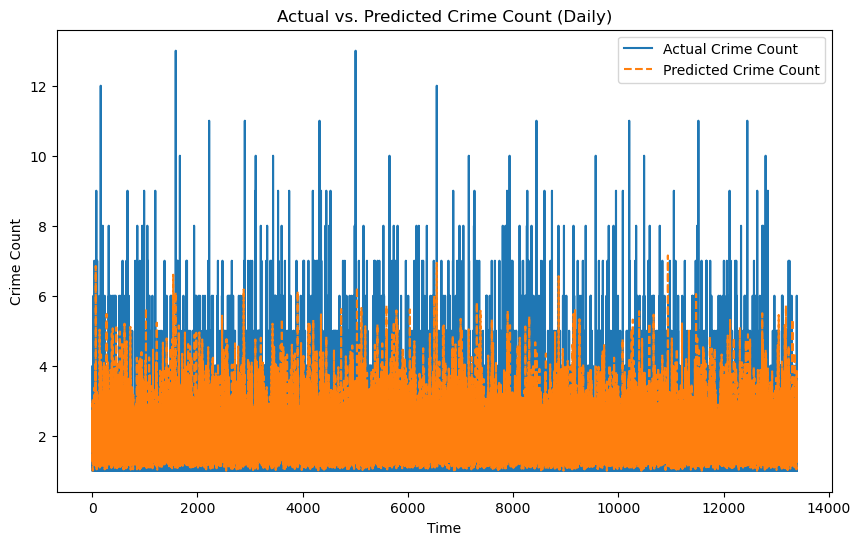

In [19]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Daily)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

Mean Absolute Error: 0.8658056008614621
Root Mean Squared Error: 1.2289371311834671
R² Score: 0.183432936668396


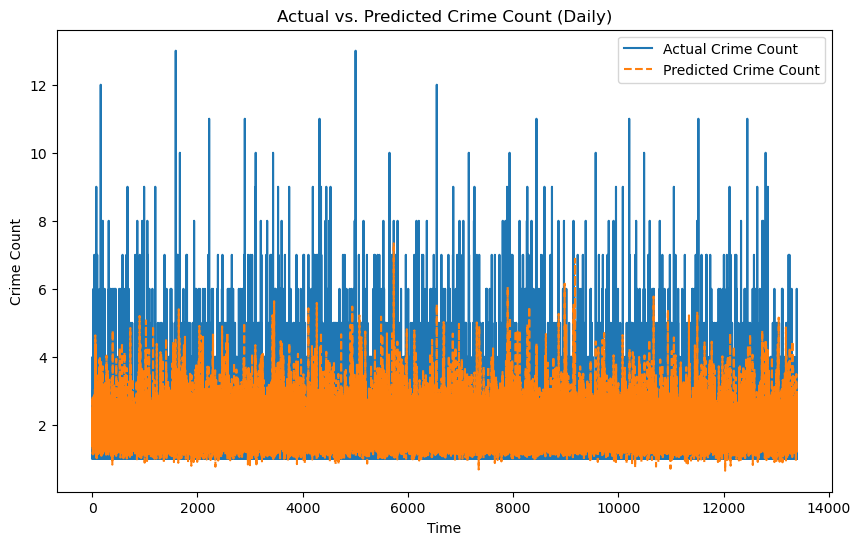

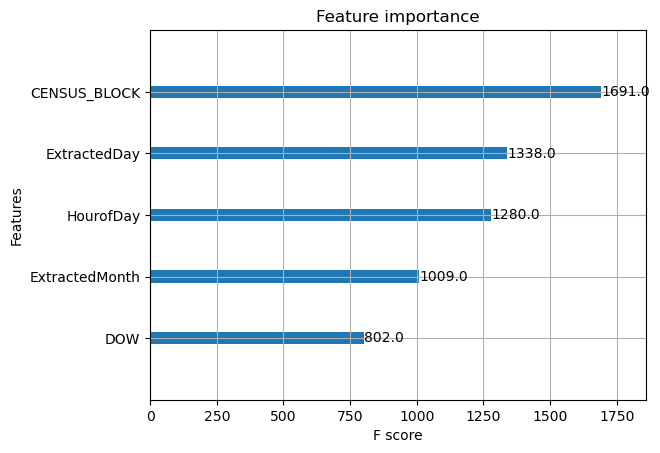

In [20]:
# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
import numpy as np

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Crime Count')
plt.plot(y_pred, label='Predicted Crime Count', linestyle='--')
plt.legend()
plt.title('Actual vs. Predicted Crime Count (Daily)')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.show()

xgb.plot_importance(xgb_model)
plt.show()